# 08. PyTorch Paper Replicating
The goal of machine learning paper replicating is: turn a ML research paper into usable code.

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture from scratch using PyTorch: An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale - https://arxiv.org/abs/2010.11929

**Abstract**

While the Transformer architecture has become the de-facto standard for natural language processing tasks, its applications to computer vision remain limited. In vision, attention is either applied in conjunction with convolutional networks, or used to replace certain components of convolutional networks while keeping their overall structure in place. We show that this reliance on CNNs is not necessary and a pure transformer applied directly to sequences of image patches can perform very well on image classification tasks. When pre-trained on large amounts of data and transferred to multiple mid-sized or small image recognition benchmarks (ImageNet, CIFAR-100, VTAB, etc.), Vision Transformer (ViT) attains excellent results compared to state-of-the-art convolutional networks while requiring substantially fewer computational resources to train.


## Source
GitHub - https://github.com/mrdbourke/pytorch-deep-learning

Website - https://www.learnpytorch.io/08_pytorch_paper_replicating/

## 0. Get setup
Let's import code we've previously written + required libraries

In [8]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves
#
# # Try to import the going_modular directory, download it from GitHub if it doesn't work
# try:
#     from going_modular.going_modular import data_setup, engine
#     from helper_functions import download_data, set_seeds, plot_loss_curves
# except:
#     # Get the going_modular scripts
#     print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
#     !git clone https://github.com/mrdbourke/pytorch-deep-learning
#     !mv pytorch-deep-learning/going_modular .
#     !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
#     !rm -rf pytorch-deep-learning
#     from going_modular.going_modular import data_setup, engine
#     from helper_functions import download_data, set_seeds, plot_loss_curves

In [9]:
# Setup device agnostic code
if torch.mps.is_available():
  device="mps"
elif torch.cuda.is_available():
  device="cuda"
else:
  device="cpu"
device

'cuda'

## 1. Get data

The whole goal of what we're trying to do is to replicate ViT architecture for our FoodVision Mini problem.

To do that, we need some data.

Namely, the pizza, steak and sushi images we've been using so far.

In [10]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data\pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


WindowsPath('data/pizza_steak_sushi')

In [11]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 2. Create DataLoaders

In [12]:
from torchvision.transforms import v2
import os

IMG_SIZE = 224 # comes from table 3 of the ViT paper
NUM_WORKERS=os.cpu_count()

# Create transform pipeline
manual_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize((IMG_SIZE,IMG_SIZE)),
    v2.ToDtype(dtype=torch.float32, scale=True)
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
      ToImage()
      Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToDtype(scale=True)
)


In [13]:
# Create a batch size of 32 (the paper uses 4096 but this may be too big for our samller hardware... can always scale later)
BATCH_SIZE=32

# Create DataLoaders
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
    )
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])


### 2.3 Visualize a single image
As always, let's adhere to the motto, **visualize, visualize, visualize!**

In [14]:
import random
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a random index for the batch of images
rand_index = random.randint(0,BATCH_SIZE-1)
image, label = image_batch[rand_index], label_batch[rand_index].item()

image.shape, label

(torch.Size([3, 224, 224]), 2)

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

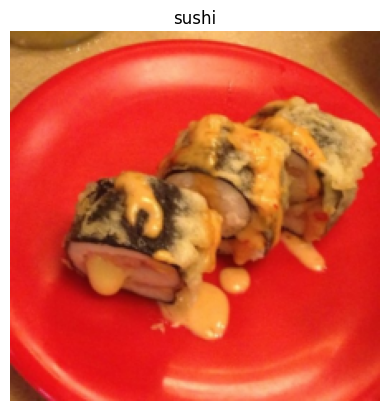

In [15]:
# Plot the image with matplotlib
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating ViT: Overview

Looking at a whole machine learning research paper can be intimidating.

So, in order to make it more understandable, we can break it down into smaller pieces:

* **Inputs** = What goes into the model? (in our case, image tensors)
* **Outputs** - What comes out of the model/layer/block? (in our case, we want the model to output image classification labels)
* **Layers** Takes an input, manipulates it with a function (for example could be self-attention).
* **Blocks** - A collection of layers.
* **Model** - A collection of blocks.

Mathpix can turn screenshots or even photos of mathnoations to text using LaTex: https://snip.mathpix.com/

### 3.1 ViT Overview: pieces of the pizzle

* Figure 1: Visual overview of the architecture
* Four equations: Math equations which define the functions of each layer/block
* Table 1/3: different hyperparameters for the architecture / training.
* Text



### Figure 1
<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-figure-1-architecture-overview.png?raw=true" width=600 alt="figure 1 from vision transformer paper">

* Embedding = learnable representation (start with random numbers and improve them over time)



### Four equations
<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-four-equations.png?raw=true" width=600 alt="four equations from vision transformer paper">

#### Section 3.1 describes the various equations:

**Equation 1**: An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where ( $H, W$ ) is the resolution of the original image, $C$ is the number of channels, ( $P, P$ ) is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1**: Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode:

```python
# Equation
x_input = [class_token, image_patch_1, image_patch_2, ..... image_patch_N]+[class_token_pos, image_patch_1_pos, image_patch_2_pos, ..... image_patch_N_pos]
```


**Equations 2&3**: The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:
```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block))+ x_output_MSA_block
```



**Equation 4**: Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time

In pseudocode:
```python
# Equation 4
y_output = Linear_layer(LN_layer(x_output_MLP_block))
```


### Table 1
<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true" width=600 alt="table 1 from vision transformer paper">

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecutres

* Layers = the number of transformer encoder layers

* Hidden size $D$ - the embedding size throughout the architecture

* MLP size - the number of hidden units / neurons in the MLP

* Head - the number of multi-head self-attention

## 4. Equation 1: Split data into patches and create the class, position, and patch embedding

Layers = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape: (224, 224, 3) -> single image -> (height, width, color channel)
* Output shape:


**Equation 1**: An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where ( $H, W$ ) is the resolution of the original image, $C$ is the number of channels, ( $P, P$ ) is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

### 4.1 Calculate input and output shapes by hand
**Equation 1**: Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input shape: $H\times(W)\times(C)$ (height x width x color channels)
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height*width)/p^2
* D = constant latent vector size = embedding dimension (see Table 1)

In [16]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height*width)/patch_size**2)
print(f"Number of patches: {number_of_patches}")

Number of patches: 196


In [17]:
# input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (signle 1D sequence of patches): {embedding_layer_output_shape} -> (number of patches, embedding_dimensions)")

Input shape (single 2D image): (224, 224, 3)
Output shape (signle 1D sequence of patches): (196, 768) -> (number of patches, embedding_dimensions)


### 4.2 Turning a single image into patches
Let's visualize, visualize, visualize!

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

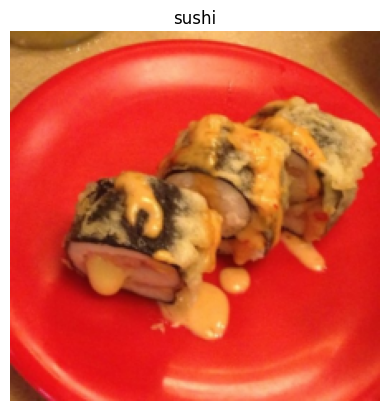

In [18]:
# View a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [19]:
image.shape

torch.Size([3, 224, 224])

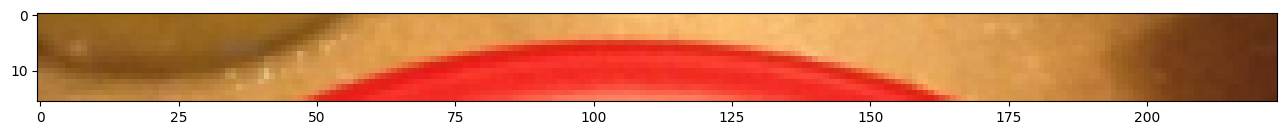

In [20]:
# Get the top row of the image
image_permuted = image.permute(1,2,0) # convert image to color channels last (H, W, C)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row:14
Patch size: 16 pixels.  
Number of patches per column:14
Patch size: 14  
Total patches: 196  
Patch size: 16 pixels x 16 pixels


Cloning into 'pytorch-deep-learning'...
Updating files:  39% (99/248)
Updating files:  40% (100/248)
Updating files:  41% (102/248)
Updating files:  42% (105/248)
Updating files:  43% (107/248)
Updating files:  44% (110/248)
Updating files:  45% (112/248)
Updating files:  46% (115/248)
Updating files:  47% (117/248)
Updating files:  48% (120/248)
Updating files:  49% (122/248)
Updating files:  50% (124/248)
Updating files:  51% (127/248)
Updating files:  52% (129/248)
Updating files:  53% (132/248)
Updating files:  54% (134/248)
Updating files:  55% (137/248)
Updating files:  56% (139/248)
Updating files:  57% (142/248)
Updating files:  58% (144/248)
Updating files:  59% (147/248)
Updating files:  60% (149/248)
Updating files:  61% (152/248)
Updating files:  62% (154/248)
Updating files:  63% (157/248)
Updating files:  64% (159/248)
Updating files:  65% (162/248)
Updating files:  66% (164/248)
Updating files:  67% (167/248)
Updating files:  68% (169/248)
Updating files:  69% (172/248)


Text(0.5, 0.98, 'sushi->Patchified')

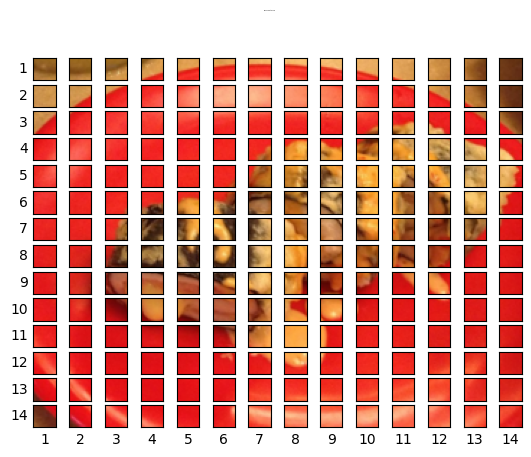

In [21]:
# Setup code to plot whole image as patches
import math
import numpy as np

image_size = 224
patch_size=16
num_patches = int(image_size / patch_size)
assert image_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row:{num_patches}\nPatch size: {patch_size} pixels.\
  \nNumber of patches per column:{num_patches}\nPatch size: {num_patches}\
  \nTotal patches: {num_patches*num_patches}\
  \nPatch size: {patch_size} pixels x {patch_size} pixels")

plot_dim = image_size // patch_size
# Create a series of subplots
fig, axs = plt.subplots(nrows=plot_dim,
                        ncols=plot_dim,  # one column for each patch
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, image_size, patch_size)):
  for j, patch_width in enumerate(range(0, image_size, patch_size)):
      axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])
      axs[i,j].set_ylabel(i+1,
                          rotation="horizontal",
                          horizontalalignment="right",
                          verticalalignment="center")
      axs[i,j].set_xlabel(j+1)
      axs[i,j].set_xticks([])
      axs[i,j].set_yticks([])
      axs[i,j].label_outer()

# Set up a title for the plot
fig.suptitle(f"{class_names[label]}->Patchified", fontsize=1)

### 4.3 Creating image patches and turning them into patch embeddings
Perhaps we could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to patch size.

In [22]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # for color channels
                   out_channels=768, # D size from Table 1 ViT-Base
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

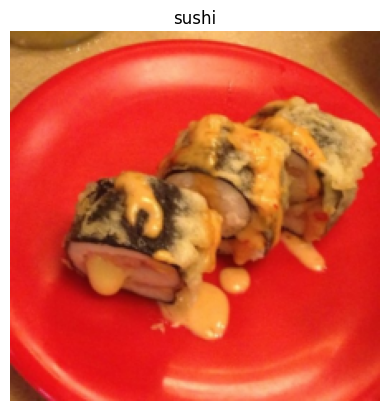

In [23]:
# View single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [24]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension => [batch_size, color_channels, height, width]
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we've passed a single image to our `conv2d` layer, it's shape is:
```python
torch.Size([1, 768, 14, 14])

# [batch_size, embedding_dim, feature_map_height, feature_map_weight
```

Showing random convolution feature maps from indices: [540, 224, 42, 166, 384]


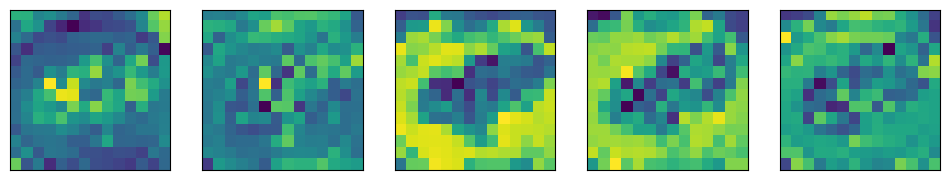

In [25]:
# plot random convolutional feature maps (embeddings)
import random
random_indices = random.sample(range(0,758),k=5)
print(f"Showing random convolution feature maps from indices: {random_indices}")

# Create plot
fig, axs = plt.subplots(nrows=1,
                         ncols=5,
                        #  sharex=True,
                        #  sharey=True,
                         figsize=(12,12))

# Plot random image feature maps
for i, idx in enumerate(random_indices):
  image_conv_feature_map = image_out_of_conv[:,idx,:,:] # index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, grad tracking, and switch to numpy for matplotlib
  axs[i].set(xticklabels=[],
             yticklabels=[],
             xticks=[],
             yticks=[])

In [26]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0757, -0.0322, -0.0635, -0.1346, -0.0755, -0.1288, -0.1407,
           -0.1721, -0.1677,  0.0178, -0.0070, -0.0407, -0.1193, -0.0546],
          [ 0.0041, -0.1838, -0.1820,  0.0039,  0.1174,  0.1384,  0.0696,
            0.0200, -0.0207, -0.0435, -0.1076, -0.1179, -0.0116, -0.0625],
          [-0.1385, -0.0693, -0.0587, -0.0877, -0.0997, -0.1423, -0.1427,
           -0.1525, -0.1559, -0.0911,  0.0298, -0.1333, -0.0722,  0.0344],
          [-0.0377, -0.0362, -0.0965, -0.1043, -0.0964, -0.1008, -0.0214,
            0.0206,  0.0680,  0.0186, -0.0017, -0.1147,  0.1449, -0.1595],
          [-0.0330, -0.1227, -0.0971, -0.0969, -0.0980, -0.0912, -0.0793,
           -0.0598, -0.0884, -0.0160, -0.1565,  0.0178, -0.0137, -0.2091],
          [-0.0787, -0.0948, -0.0734, -0.0694,  0.0294, -0.0327,  0.0361,
           -0.1813,  0.1625, -0.0862, -0.1242, -0.1845, -0.0205, -0.1334],
          [-0.1003, -0.1023,  0.0900, -0.0272, -0.0254,  0.1367,  0.0468,
            0.0593,  0.0931, -0.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`
Right now we've got a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the criteria of the ViT Transformer Encoder.

In [27]:
print(f"{image_out_of_conv.shape} -> [batch_size, embedding_dim, feature_map_height, feature_map_width]")

torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]


Want: (batch_size, number_of_patches, embedding_dim)

In [28]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                          end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


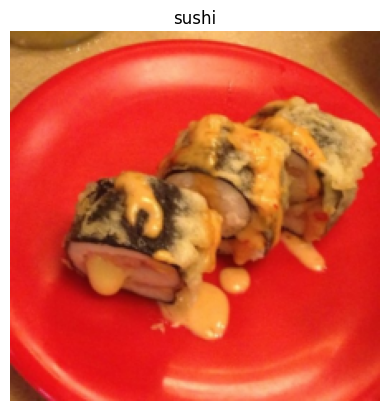

In [29]:
# Put everything togeter
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [30]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)
print(f"{image_out_of_conv_flattened_permuted.shape}->(batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768])->(batch_size, number_of_patches, embedding_dimension)


(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

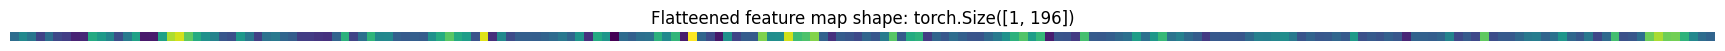

In [31]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:,:,0]
single_flattened_feature_map # one embedding vector

# Plot the flattened feature map visually
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flatteened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

### 4.5 Turning the ViT patch embedding layer into a PyTorch module
We want this module to do a few things:
1. Create a class called `PatchEmbedding`
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedded patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` method that defines the forward computation (e.g. pass through layer from 3 and 4)
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.


In [32]:
import torch
from torch import nn

# 1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
  # 2. Initialize the layer with appropriate hyperparameters
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768,): # from Table1, defaults for a ViT-Base model
    """
    Returns the patch embedding for a given image in the shape of
    (batch_size, number_of_patches, embedding_dim)
    Args:
      in_channels (int) - Number of color channels in the image
      embedding_dim (int) - Number of embedding dimensions for the vector
      patch_size (int) - Patch size, image_resolution % patch_size must be 0
    """
    super().__init__()
    self.patch_size = patch_size
    # 3. Create a layer to turn an image into embedded patches
    self.patch_and_flatten = nn.Sequential(
        nn.Conv2d(in_channels=in_channels,
                  out_channels=embedding_dim,
                  kernel_size=patch_size,
                  stride=patch_size),
        # 4. Create a layer to flatten the feature map outputs of Conv2d
        nn.Flatten(start_dim=2,
                              end_dim=3)
    )

  # 5. Define a forward method to define the forward computation steps
  def forward(self, x:torch.Tensor):
    # Create assertion to check that inputs are the correct shape
    height, width = x.shape[-2],x.shape[-1]
    assert height % self.patch_size == 0 and width % self.patch_size == 0, f"Input image size must be divisible by patch size, image height: {height}, image width: {width}, patch_size: {patch_size}"

    # Perform the forward pass
    x = self.patch_and_flatten(x)
    x = x.permute(0,2,1)
    # Return the sequence embedding dimension in the right order(batch_size, number_of_patches, embedding_dimension)
    return x

In [33]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a signle image through the patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [34]:
# Test to see if the assertion works in PatchEmbedding forward() method
rand_image_tensor = torch.randn(1,3,224,224)
rand_image_tensor_bad = torch.randn(1,3,250,250)

# patchify(rand_image_tensor_bad)

### 4.6 Creating the class token embedding
Want to: prepend a learnable class token to the start of the patch embedding.

In [35]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [36]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [37]:
# Create class token embedding as a learnable parameter that share the same size as the embedding dimension(0)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad = True)
class_token.shape

torch.Size([1, 1, 768])

In [38]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat(
    (class_token, patch_embedded_image),
    dim=1) # number_of_patches dimension
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)")

Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim)


### 4.7 Creating the position embedding

Want to: create a series of 1D learnable position embeddings and add them to the sequence of patch embeddings.

In [39]:
# Voew the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.4863,  0.0423, -0.1511,  ...,  0.2779, -0.2365,  0.1976],
          [-0.5074,  0.0786, -0.1432,  ...,  0.3041, -0.2911,  0.1613],
          ...,
          [-0.6637, -0.0663, -0.0624,  ...,  0.3660, -0.3921,  0.2844],
          [-0.6193, -0.0239, -0.0852,  ...,  0.3110, -0.2955,  0.2785],
          [-0.5729, -0.0957,  0.0432,  ...,  0.1739, -0.3164,  0.2667]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [40]:
# Calculate N (number_of_patches)
number_of_patches = int((height*width/patch_size**2))

# Get the embedding dimension
embedding_dimension = (patch_size**2)*3 #3 is the number of colour channels

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)
number_of_patches, embedding_dimension, position_embedding.shape

(196, 768, torch.Size([1, 197, 768]))

In [41]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape} ")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.5137, 1.0423, 0.8489,  ..., 1.2779, 0.7635, 1.1976],
         [0.4926, 1.0786, 0.8568,  ..., 1.3041, 0.7089, 1.1613],
         ...,
         [0.3363, 0.9337, 0.9376,  ..., 1.3660, 0.6079, 1.2844],
         [0.3807, 0.9761, 0.9148,  ..., 1.3110, 0.7045, 1.2785],
         [0.4271, 0.9043, 1.0432,  ..., 1.1739, 0.6836, 1.2667]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768]) 


In [42]:
# Update PatchEmbedding class with class token and position embedding
import torch
from torch import nn

class PatchEmbedding(nn.Module):
  def __init__(self,
               image_size:int,
               color_channels:int=3,
               patch_size:int=16,
               embedding_dropout:float=0.1, # Dropout for patch and position embeddings
               embedding_dim:int=768,): # from Table1, defaults for a ViT-Base model
    """
    Returns the patch embedding for a given image in the shape of
    (batch_size, number_of_patches, embedding_dim)
    Image must be of square shape: H == W
    Args:
      image_size (int) - Image H / W, image_size % patch_size must be 0
      color_channels (int) - Number of color channels in the image
      patch_size (int) - Patch size, image_size % patch_size must be 0
      embedding_dropout (float), Dropout for patch and position embeddings
      embedding_dim (int) - Number of embedding dimensions for the vector
    """
    super().__init__()
    self.patch_size = patch_size
    assert image_size % self.patch_size == 0, f"Input image size must be divisible by patch size, image size: {image_size}, patch_size: {patch_size}"
    self.number_of_patches = int((image_size**2)/(patch_size**2)) # Assuming square image
    self.patch_and_flatten = nn.Sequential(
        nn.Conv2d(in_channels=color_channels,
                  out_channels=embedding_dim,
                  kernel_size=patch_size,
                  stride=patch_size),
        nn.Flatten(start_dim=2,
                              end_dim=3)
    )
    self.class_token = nn.Parameter(torch.rand(1,
                                               1,
                                               embedding_dim),
                                    requires_grad=True)
    self.position_embedding = nn.Parameter(torch.rand(1,
                                                      number_of_patches+1,
                                                      embedding_dim),
                                           requires_grad=True)
    self.dropout = nn.Dropout(p=embedding_dropout)

  def forward(self, x:torch.Tensor):
    # Get batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_token.expand(batch_size,-1,-1) # -1 means to infer the dimensions

    # Create the patch embedding (equation 1)
    x = self.patch_and_flatten(x)

    # Set the sequence embedding dimension in the right order(batch_size, number_of_patches, embedding_dimension)
    x = x.permute(0,2,1)

    # Prepend the class token
    x = torch.cat((class_token,x),
                  dim=1)

    # Add the position embedding
    x = x + self.position_embedding

    # Apply dropout to patch embedding ("directly after adding positional - to patch embeddings")
    x = self.dropout(x)
    return x

In [43]:
# 1. Set seeds
set_seeds()

# 2. Set patch_size
patch_size = 16

# 2. Print the shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Set embedding dim
embedding_dim = 768

# 5. Create patch embedding layer with class token and position embedding
patch_embedding = PatchEmbedding(
    image_size=height,
    color_channels=x.shape[1],
    patch_size=patch_size,
    embedding_dim = 768
)

# 6. Get the patches with class token and position embedding
patch_and_position_embedding = patch_embedding(x)
print(f"Shape of image with patch, class token, and position embedding: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Shape of image with patch, class token, and position embedding: torch.Size([1, 197, 768])


## Equation 2: Multihead Self-Attention (MSA block):
* Multihead self-attention: which part of a sequence should pay the most attention to itself?
  * In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
  * We want our neural network (ViT) to learn this relationship/representation.
* To replicate this in PyTorch, we can use:
https://docs.pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html
* LayerNorm = Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
  * Normalization = make everything have the same mean and same standard deviation
  * In PyTorch = https://docs.pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

Normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension.
  * When we normalize along the embedding dimension, it is like making all of the stairs in staircases the same size.


In [44]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """Creates a mult-head self-attention block ("MSA block" for short)
  Args:
    embedding_dim (int) - Embedding dimensions, 768 by default for ViT-Base
    num_heads (int) - Number of heads for the mult-head self-attention
    attn_dropout (float) - Dropout rate for multihead self attention
  """
  def __init__(self,
               embedding_dim:int=768, # Hidden size D (embedding dimension) from Table 1 for ViT-Base
               num_heads:int=12, # Heads from Table 1 for ViT-Base
               attn_dropout:float=0):
    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create multihead attention (MSA) layer
    self.multi_head_attention = nn.MultiheadAttention(
        embed_dim=embedding_dim,
        num_heads=num_heads,
        dropout=attn_dropout,
        batch_first=True) # is the batch first? (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)

  def forward(self, x:torch.Tensor):
    normalized_x = self.layer_norm(x)
    attn_output, _ = self.multi_head_attention(query=normalized_x,
                                               key=normalized_x,
                                               value=normalized_x,
                                               need_weights=False)
    return attn_output


In [45]:
set_seeds()

# Create an instance of MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(
    embedding_dim=768,
    num_heads=12,
    attn_dropout=0
)

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


## 6. Equation 3: Multilayer Perceptron (MLP block)
* **MLP** = The MLP contains two layers with a GELU non-linearity (section 3.1).
  * MLP = a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer.
  * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In PyTorch, they're often called `torch.nn.Linear()` and in TensorFlow they're called `tf.keras.layers.Dense()`
  * GELU in PyTorch - https://docs.pytorch.org/docs/stable/generated/torch.nn.GELU.html
  * **Dropout** - Dropout, when used, is applied after every dense (linear) layer except for the the qkv-projections and directly after adding positional- to patch embeddings
    * Value for dropout available in table 3

In pseudocode:
```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```


In [46]:
class MLPBlock(nn.Module):
  """Takes the output of the MSA block and returns the prediction logits added
  to the input.
  Args:
    embedding_dim (int) = Embedding dimension, default 768 for ViT-Base
    mlp_size (int) = Features for MLP block, default 768 for ViT-Base
    dropout (float) = Dropout rate between 0 and 1, default 0.1 for ViT-Base
  """
  def __init__(self,
               embedding_dim:int=768,
               mlp_size=3072,
               dropout:float=0.1):
    super().__init__()

    # Create the layer norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x:torch.Tensor):
    normalized_x = self.layer_norm(x)
    mlp_x = self.mlp(normalized_x)
    return mlp_x

In [47]:
set_seeds()

# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output of MSA block through MLP block
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f'Input shape of MSA block: {patched_image_through_mlp_block.shape}')

Input shape of MLP block: torch.Size([1, 197, 768])
Input shape of MSA block: torch.Size([1, 197, 768])


In [48]:
patched_image_through_msa_block

tensor([[[-0.1829,  0.0292,  0.1896,  ...,  0.1018,  0.1784,  0.1486],
         [-0.1902,  0.0448,  0.2058,  ...,  0.0774,  0.1801,  0.1810],
         [-0.1578,  0.0230,  0.2015,  ...,  0.0856,  0.1702,  0.1450],
         ...,
         [-0.1763,  0.0437,  0.1872,  ...,  0.0818,  0.1795,  0.1656],
         [-0.1923,  0.0342,  0.2166,  ...,  0.0798,  0.1709,  0.1423],
         [-0.1792,  0.0510,  0.2182,  ...,  0.0860,  0.1698,  0.1522]]],
       grad_fn=<TransposeBackward0>)

In [49]:
patched_image_through_mlp_block

tensor([[[-0.2144,  0.1770,  0.2690,  ..., -0.0480,  0.2863, -0.1409],
         [-0.2473,  0.2501,  0.1506,  ...,  0.1055,  0.3676, -0.0138],
         [-0.2790,  0.3354,  0.1973,  ...,  0.1823,  0.3379, -0.0300],
         ...,
         [-0.2422,  0.3132,  0.0000,  ...,  0.1332,  0.2419,  0.0478],
         [-0.1620,  0.2806,  0.1859,  ...,  0.1266,  0.3886, -0.2123],
         [-0.0000,  0.2691,  0.1690,  ...,  0.1909,  0.0584,  0.0481]]],
       grad_fn=<MulBackward0>)

## 7. Creating the Transformer Encoder
The transformer encoder is alternating blocks of MSA (equation 2) and MLP (equation 3).

And there are residual connections between each block.
* Encoder - turn a sequence into learnable representation
* Decoder - go from learn representation back to some sort  of sequence
* Residual connections - add a layer(s) input to its subsequent output, this enables the creation of deeper networks (prevents weights from getting too small)

In pseudocode:
```python
x_input -> MSA_block -> [MSA_block_output+x_input] -> MLP_block -> [MLP_block_output+MSA_block_output+x_input] -> ...
```



In [50]:
### 7.1 Create a custom Transformer Encoder block

In [51]:
import torch
from torch import nn

class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768, # Hidden size D (embedding dimension) from Table 1 for ViT-Base
               num_heads:int=12, # Heads from Table 1 for ViT-Base
               attn_dropout:float=0,
               mlp_size=3072,
               mlp_dropout:float=0.1):
    """
    Passes embedded patches through a multihead self attention (MSA) block and
    multilayer perceptron (MLP) block
    Args:
      embedding_dim (int) - Embedding dimension for the vector, 769 for ViT-Base
      num_heads (int) - Number of heads for the mult-head self-attention
      attn_dropout (float) - Dropout rate for multihead self attention
      mlp_size (int) = Features for MLP block, default 768 for ViT-Base
      mlp_dropout (float) = Dropout rate between 0 and 1, default 0.1 for ViT-Base
    """
    super().__init__()

    # Create MSA block (equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(
        embedding_dim=embedding_dim,
        num_heads=num_heads,
        attn_dropout=attn_dropout
    )

    # Create MLP block (equation 3)
    self.mlp_block = MLPBlock(
        embedding_dim=embedding_dim,
        mlp_size=mlp_size,
        dropout=mlp_dropout
    )

  def forward(self, x:torch.Tensor):
    x = self.msa_block(x) + x # residual/skip connection for equation 2
    x = self.mlp_block(x) + x # residual/skip connection for equation 3
    return x

In [52]:
# Create an instance of TransformerEncoderBlock()
set_seeds()
transformer_encoder = TransformerEncoderBlock(embedding_dim=768, # Hidden size D from table 1, 768 for ViT-Base
                                         num_heads=12, # from table 1
                                         attn_dropout=0, # from table 1
                                         mlp_size=3072, # from table 1
                                         mlp_dropout=0.1) # from table 3

encoded_image = transformer_encoder(patch_and_position_embedding)
print(f"Shape of transformer encoder input: {patch_and_position_embedding.shape}")
print(f"Shape of transformer encoder output: {encoded_image.shape}")
encoded_image

Shape of transformer encoder input: torch.Size([1, 197, 768])
Shape of transformer encoder output: torch.Size([1, 197, 768])


tensor([[[-0.2615,  1.3942,  0.7879,  ...,  1.4664,  0.8530,  0.6869],
         [-0.0268,  0.2965,  0.8014,  ...,  1.0413,  0.8257,  1.2769],
         [ 0.0238, -0.3525,  0.9054,  ...,  0.7905, -0.1112,  0.7951],
         ...,
         [-0.1031,  0.3243,  0.1780,  ...,  1.1493, -0.0017,  1.0895],
         [-0.6568,  0.0768,  0.7147,  ...,  1.4213, -0.1015,  0.5764],
         [-0.5022, -0.0117,  1.0701,  ...,  1.0157,  0.1698,  0.7590]]],
       grad_fn=<AddBackward0>)

In [53]:
# Get a summary using torchinfo.summary
summary(model=transformer_encoder,
        input_size=(1,197,768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multi_head_attention)        --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

### 7.2 Create a Transformer Encoder layer with in-built PyTorch layers
So far we've create a transformer encoder model by hand.

But because of how good the Transformer architecture is, PyTorch has implemented ready to use Transformer Encoder layers: https://docs.pytorch.org/docs/stable/generated/torch.nn.Transformer.html

We can create a Transformer Encoder with pure PyTorch layers:
https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html

In [54]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # embedding size from table 1
                                                             nhead=12, # heads from table 1
                                                             dim_feedforward=3072, # MLP size from table 1
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True
                                                             )
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [55]:
# Get a summary using torchinfo.summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1,197,768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

Why spend all this time recreating the transformer encoder when we could've just made it with a singly PyTorch layer?

For practice so that replicating newer paper is not too difficult in the future.

We can also tweak the implementation as needed because we know how it works now.

What are the benefits of using pre-buily PyTorch models?
* Less prone to errors
* Potentially better performance

## 8. Putting it all together to create ViT

In [56]:
# Create a ViT class
class ViT(nn.Module):
  def __init__(self,
               img_size:int=224, # Table 3 from the ViT paper
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layer:int=12, # Table 1 for `Layer` for ViT-Base
               embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
               mlp_size:int=3072,
               num_heads:int=12, # Table1
               attn_dropout:float=0,
               mlp_dropout:float=0.1,
               embedding_dropout:int=0.1, # Dropout for patch and position embeddings
               num_classes:int=1000): # number of classes in our classification problem
    super().__init__()

    # Create the patch embedding block
    self.patch_embedding_block = PatchEmbedding(
        image_size=image_size,
        patch_size=patch_size,
        embedding_dim=embedding_dim,
        embedding_dropout=0.1)

    # Create the transformer encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(
        embedding_dim=embedding_dim,
        num_heads=num_heads,
        attn_dropout=attn_dropout,
        mlp_size=mlp_size,
        mlp_dropout=mlp_dropout
    ) for _ in range(num_transformer_layer)])

    # Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dimension,
                  out_features=num_classes)
    )

  def forward(self, x:torch.Tensor):
    # Get position and patch embedding (equation 1)
    x = self.patch_embedding_block(x)

    # Pass position and patch embedding through transformer encoder (equations 2 and 3)
    x = self.transformer_encoder(x)

    # Put 0th index logit through the classifier
    x = self.classifier(x[:,0])
    return x


In [57]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1,3,224,224)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, and sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image through the ViT instance
vit(random_image_tensor)

tensor([[ 0.6136, -0.9092,  0.5918]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of our ViT model

In [58]:
from torchinfo import summary

summary(model=ViT(num_classes=1000),
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                         [32, 3, 224, 224]    [32, 1000]           --                   True
├─PatchEmbedding (patch_embedding_block)                          [32, 3, 224, 224]    [32, 197, 768]       152,064              True
│    └─Sequential (patch_and_flatten)                             [32, 3, 224, 224]    [32, 768, 196]       --                   True
│    │    └─Conv2d (0)                                            [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    │    └─Flatten (1)                                           [32, 768, 14, 14]    [32, 768, 196]       --                   --
│    └─Dropout (dropout)                                          [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           

Model training to be continued